In [1]:
print("start")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from torchvision import datasets, transforms
import sys
import random
sys.path.append('../../')
from src.models.frequency.sketch_algorithms import SketchQueryalgorithms
from src.datasets.zipf import get_zipf_probs, get_dataset_samples, ZipfOnlineDatasetLoader
device = 'cuda:0'

start


In this notebook we fix the sketch size to a number, and try several combinations of d (num linear projection) and w (dim linear projection) (d*w=sketch size) several times with 3 datasets and count sketch and count min sketch algorithms.
We try to fix the sketch size to 10% (100) and 1% (10) of the input dimension of the dataset.
We plot the mean of the features of the dataset with each combination of d and w, and the MSE of each.
The number of samples used is 1000

# Functions

We define some functions that will be used in the notebook

In [2]:
def MSE_plot_count(list_w,list_d,err_cs,err_cm,space_alpha):
    """
    This function plots the evolution mean and std of the MSE error for the different runs and different combinations of d and w.
    """
    x_3 = 0
    # Compute mean
    mean_steps_cm = np.nanmean(err_cm, axis=0)
    mean_steps_cs = np.nanmean(err_cs, axis=0)
    # Compute std
    std_steps_cm = np.nanstd(err_cm, axis=0) 
    std_steps_cs = np.nanstd(err_cs, axis=0) 
    fig = plt.figure(figsize=(11, 8)) 
    for i in range(len(space_alpha)):
        x_3 += 1
        ax = fig.add_subplot(2,2,x_3)
        
        # Log scale in the x axis
        ax.set_xscale('symlog')
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        plt.errorbar(list_w, mean_steps_cm[i], yerr = std_steps_cm[i], fmt = 's',color = 'darkturquoise', 
                    ecolor = 'darkturquoise',markeredgewidth=1,label='W CM',ls='dashed',elinewidth=1) #, elinewidth = 1, capsize=10

        plt.errorbar(list_d, mean_steps_cm[i], yerr = std_steps_cm[i], fmt = '-s',color = 'darkturquoise', 
                    ecolor = 'darkturquoise',markeredgewidth=1,label='D CM',elinewidth=1) #, elinewidth = 1, capsize=10
        plt.errorbar(list_w, mean_steps_cs[i], yerr = std_steps_cs[i], fmt = 'o',color = 'violet', 
                    ecolor = 'violet',markeredgewidth=1,label='W CS',ls='dashed',elinewidth=1) #, elinewidth = 1, capsize=10

        plt.errorbar(list_d, mean_steps_cs[i], yerr = std_steps_cs[i], fmt = '-o',color = 'violet', 
                    ecolor = 'violet',markeredgewidth=1,label='D CS',elinewidth=1) #, elinewidth = 1, capsize=10

        #plt.title("Evolution of the MSE Loss")
        plt.title("Beta 1.0, Alpha {}".format(space_alpha[i]),fontsize=10)
        plt.xlabel("w or d")
        plt.ylabel("MSE loss")
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    plt.legend(loc='center left', bbox_to_anchor=(1, 2.1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.25)
    # Save plot if sketch size is 100
    if list_w[0]*list_d[0]==100:
        plt.savefig('../../results/plots_CM_CS_BF/CS_CM_MSE_dw_sk100.png', bbox_inches='tight')
    plt.show()
    plt.close()  
    

In [3]:
def count_algorithms(list_w,list_d,n_dims):
    space_alpha = [0.5,1.0,1.5 ,2.0]
    runs = 10
    num_samples = 100 #1000
    n_dims = 1000 # Input dimention
    beta = 1.0
    err_cm = np.zeros([runs,len(space_alpha),len(list_w)])
    err_cs = np.zeros([runs,len(space_alpha),len(list_w)])

    for run in range(runs):
        iter_alpha = 0
        for alpha in list(space_alpha):
            # Generating dataset
            zipfdatasetloader = ZipfOnlineDatasetLoader(500, n_dims, num_samples, alpha_min=alpha, alpha_max=alpha,beta_min=beta, beta_max=beta,device=device)
            errors_cs = []
            errors_cm = []
            for i in range(len(list_w)):
                w = list_w[i]
                d = list_d[i]

                # Compute count sketch 
                countsketch = SketchQueryalgorithms(n_dims, w, d,'CS')
                # Compute count min sketch 
                countminsketch = SketchQueryalgorithms(n_dims, w, d,'CM')
                er_cs = []
                er_cm = []
                # Iterate the batches and take just the first batch
                for j, (x,y) in enumerate(zipfdatasetloader):
                    if j == 0:     
                        for batch in range(x.shape[0]):
                            x_i = x[batch].cpu()
                            y_i = y[batch].cpu()

                            # Compute CS
                            y_hat, s = countsketch.SketchQuery_algorithms(x_i)
                            error = torch.mean(torch.square(torch.clamp(y_hat, 0, 1)-y_i.squeeze()))
                            er_cs.append(error.item())

                            # Compute CM
                            y_hat, s = countminsketch.SketchQuery_algorithms(x_i)
                            error = torch.mean(torch.square(torch.clamp(y_hat, 0, 1)-y_i.squeeze()))
                            er_cm.append(error.item())

                        errors_cs.append(np.mean(er_cs))
                        errors_cm.append(np.mean(er_cm))  

            err_cs[run,iter_alpha,:] = errors_cs
            err_cm[run,iter_alpha,:] = errors_cm
            iter_alpha += 1
    return err_cs,err_cm,space_alpha


In [4]:
def count_min_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,data,idx):
    """
    This function computes the count min sketch for different d and w, and plots the reconstructed mean of the dataset.
    The reconstructed mean is the mean of several runs of the same d and w changing the W matrix.
    """
    # Check data shape
    if len(x.shape) == 3:
        # If there is batch size dim (Batch_size_dim x num_samples x n_dim) = (Batch_size_dimxnum_samples) x n_dim (2 dim)
        # Convert tensor of three dimencions to two
        x = x.view(x.shape[0]*x.shape[1],x.shape[2])
    plt.figure(figsize=(10, 10)) 
    runs = 5
    err = np.zeros([runs,len(list_w)])
    x_hat_all = np.zeros([runs,len(list_w),n_dims])
    for run in range(runs):
        loss =[]
        # Compute the algorithm for each combination
        for i in range(len(list_w)):
            w = list_w[i]
            d = list_d[i]
            countmin = SketchQueryalgorithms(n_dims, w, d,'CM')
            if data == 'Genetics' or data == 'MNIST':
                # sort dataset 
                order_features = x[:,idx]
                ## Computing the mean of samples BEFORE projection
                countmin.mean_mode = 'before'
                x_hat, s = countmin.SketchQuery_algorithms(order_features)
                x_mean = torch.mean(order_features, dim=0)
            else:
                ## Computing the mean of samples BEFORE projection
                countmin.mean_mode = 'before'
                x_hat, s = countmin.SketchQuery_algorithms(x)
                x_mean = torch.mean(x, dim=0)            
            error = torch.mean(torch.square(x_hat-x_mean))
            loss.append(error.item())
            x_hat_all[run,i,:] = x_hat.cpu().detach().numpy()
        err[run,:] = loss
    
    # Compute the mean of reconstructed frequencies of the several runs for each w and d
    for j in range(len(list_w)):
        w = list_w[j]
        d = list_d[j]
        plt.subplot(x_1, x_2, x_3)
        x_3 += 1
        plt.plot(np.nanmean(x_hat_all, axis=0)[j], 'b',markersize=1)

        plt.title("d:{},w:{}".format(d,w),fontsize=8)
        plt.xlabel("n_dim",fontsize=8)
        plt.ylabel("freq",fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)


    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.9)
    plt.suptitle('Reconstructed mean for a particular d and w',fontsize=14)
    plt.show()
    plt.close()
        
    return err    
    

In [5]:
def count_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,data,idx):
    """
    This function computes the count sketch for different d and w, and plots the reconstructed mean of the dataset.
    The reconstructed mean is the mean of several runs of the same d and w changing the W matrix.
    """
    # Check data shape
    if len(x.shape) == 3:
        # If there is batch size dim (Batch_size_dim x num_samples x n_dim) = (Batch_size_dimxnum_samples) x n_dim (2 dim)
        # Convert tensor of three dimencions to two
        x = x.view(x.shape[0]*x.shape[1],x.shape[2])
    plt.figure(figsize=(10, 10)) 
    #loss = []
    runs = 10
    err = np.zeros([runs,len(list_w)])
    x_hat_all = np.zeros([runs,len(list_w),n_dims])
    for run in range(runs):
        loss =[]
        # Compute the algorithm for each combination
        for i in range(len(list_w)):
            w = list_w[i]
            d = list_d[i]
            countsketch = SketchQueryalgorithms(n_dims, w, d,'CS')

            # sort dataset 
            if data == 'Genetics' or data == 'MNIST':
                order_features = x[:,idx]
                ## Computing the mean of samples BEFORE projection
                countsketch.mean_mode = 'before'
                x_hat, s = countsketch.SketchQuery_algorithms(order_features)
                x_mean = torch.mean(order_features, dim=0)
            else:
                countsketch.mean_mode = 'before'
                x_hat, s = countsketch.SketchQuery_algorithms(x)
                x_mean = torch.mean(x, dim=0)

            error = torch.mean(torch.square(x_hat-x_mean))
            loss.append(error.item())
            x_hat_all[run,i,:] = x_hat.cpu().detach().numpy()
        err[run,:] = loss

    # Compute the mean of reconstructed frequencies of the several runs for each w and d
    for j in range(len(list_w)):
        w = list_w[j]
        d = list_d[j]
        plt.subplot(x_1, x_2, x_3)
        x_3 += 1
        plt.plot(np.nanmean(x_hat_all, axis=0)[j], 'b',markersize=1)

        plt.title("d:{},w:{}".format(d,w),fontsize=8)
        plt.xlabel("n_dim",fontsize=8)
        plt.ylabel("freq",fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)


    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.9)

    plt.suptitle('Reconstructed mean for a particular d and w',fontsize=14)
    plt.show()
    plt.close()
        
    return err   
    

In [6]:
def mean_dataset(x):
    """
    This function plots the mean of the features of the dataset.
    """
    # Check data shape
    if len(x.shape) == 3:
        # If there is batch size dim (Batch_size_dim x num_samples x n_dim) = (Batch_size_dimxnum_samples) x n_dim (2 dim)
        # Convert tensor of three dimencions to two
        x = x.view(x.shape[0]*x.shape[1],x.shape[2])
    plt.plot(torch.mean(x, dim=0).cpu().detach().numpy(),'b')
    plt.title("Mean of the features of the dataset")
    plt.xlabel("n_dim")
    plt.ylabel("freq")
    plt.show()    
    plt.close()

In [7]:
def MSE_plot(list_w,list_d,err):
    """
    This function plots the evolution of the MSE error of the different combinations of d and w.
    Every w and d are tested 10 times, and the mean and sd of the errors are computed.
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    ax.set_xscale('symlog')
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    mean_steps = np.nanmean(err, axis=0)
    std_steps = np.nanstd(err, axis=0) 
    plt.errorbar(list_w, mean_steps, yerr = std_steps, fmt = '-o',color = 'orange', 
                ecolor = 'black',markeredgewidth=1,label='W') #, elinewidth = 1, capsize=10

    plt.errorbar(list_d, mean_steps, yerr = std_steps, fmt = '-o',color = 'blue', 
                ecolor = 'black',markeredgewidth=1,label='D') #, elinewidth = 1, capsize=10

    plt.legend()
    plt.title("Evolution of the MSE Loss")
    plt.xlabel("w or d")
    plt.ylabel("MSE loss")
    plt.show()
    plt.close()    
    
    
    """"
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    ax.set_xscale('symlog')
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.plot(list_w,loss,label='W')
    plt.plot(list_d,loss,label='D')

    plt.legend()
    plt.title("Evolution of the MSE Loss")
    plt.xlabel("w or d")
    plt.ylabel("MSE loss")
    plt.show()
    plt.close()
    """
    


In [8]:
def plot_mean_features(data): 
    """
    This function plots the mean of the features of the MNIST and genetics dataset.
    """
    # Check data shape
    if len(data.shape) == 3:
        # If there is batch size dim (Batch_size_dim x num_samples x n_dim) = (Batch_size_dimxnum_samples) x n_dim (2 dim)
        # Convert tensor of three dimencions to two
        data = data.view(data.shape[0]*data.shape[1],data.shape[2])
    mean_features = torch.mean(data, dim=0)
    mean_features_sort = torch.sort(mean_features,descending=True)
    idx = mean_features_sort.indices
    if len(data.shape) > 1:
        shape = data.shape[1]
    else:
        shape = data.shape[0]
    x_axis = torch.arange(0, shape)
    plt.figure
    plt.plot(x_axis,mean_features_sort.values.cpu().detach().numpy(),'b')
    plt.title('Mean features', fontsize = 12)
    plt.show()
    #name_file = hparams['save_name'] + '/Loss_real.png'
    #plt.savefig(name_file) # ,dpi=300
    plt.close() 
    return idx

In [9]:
# Read data
data_MNIST = np.load('../../results/datasets/datasets_sketch/MNIST.npz')
data_humans = np.load('../../results/datasets/datasets_sketch/humans.npz')

# Zipf dataset

## Sketch size = d * w = 100 (10% input dimention)

#### count min sketch

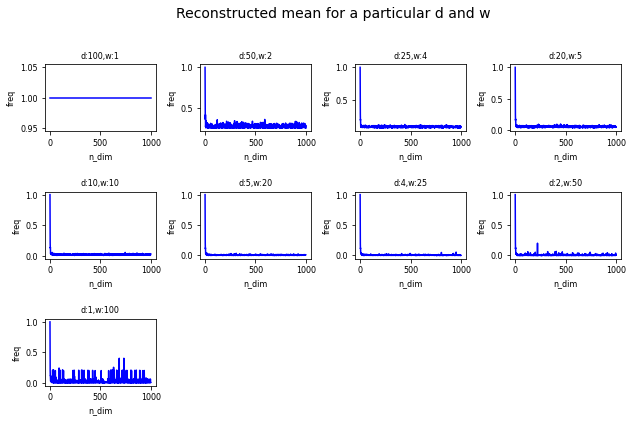

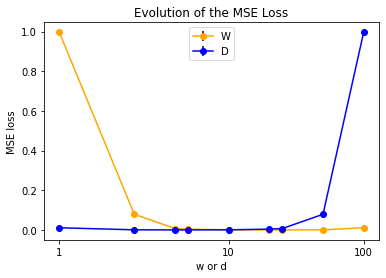

In [27]:
## Generating dataset
num_samples = 100
n_dims = 1000 # Input dimention
alpha = 1.5
beta = 0.5
ps = get_zipf_probs(n_dims, alpha, beta)
x = torch.bernoulli(ps.repeat(num_samples,1))
mean_dataset(x)

## Creating count-min sketch
list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_min_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'zipf',0)
MSE_plot(list_w,list_d,loss)

#### count sketch

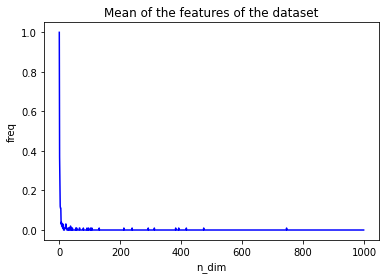

In [28]:
## Generating dataset
num_samples = 100
n_dims = 1000 # Input dimention
alpha = 1.5
beta = 0.5
ps = get_zipf_probs(n_dims, alpha, beta)
x = torch.bernoulli(ps.repeat(num_samples,1))
mean_dataset(x)

## Creating count-min sketch
list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'zipf',0)
MSE_plot(list_w,list_d,loss)

In [57]:
n_dims = 1000 # Input dimention

## Creating count-min sketch
list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1]

err_cs,err_cm,space_alpha = count_algorithms(list_w,list_d,n_dims)

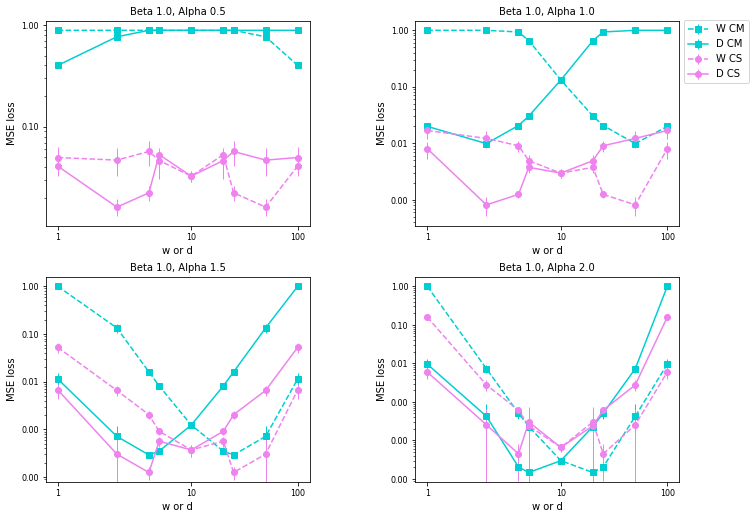

In [59]:
MSE_plot_count(list_w,list_d,err_cs,err_cm,space_alpha)

## Sketch size = d * w = 10 (1% input dimention)

#### count min sketch

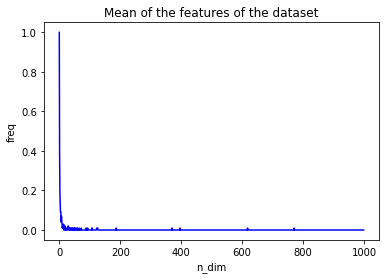

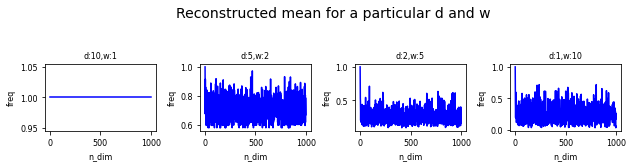

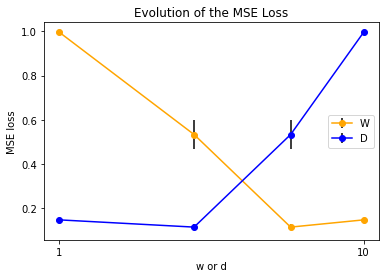

In [31]:
## Generating dataset
num_samples = 100
n_dims = 1000 # Input dimention
alpha = 1.5
beta = 0.5
ps = get_zipf_probs(n_dims, alpha, beta)
x = torch.bernoulli(ps.repeat(num_samples,1))
mean_dataset(x)

## Creating count-min sketch
list_w = [1,2,5,10]
list_d = [10,5,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_min_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'zipf',0)
MSE_plot(list_w,list_d,loss)

#### Count sketch

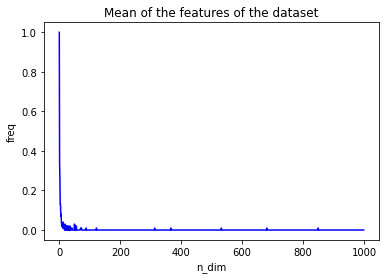

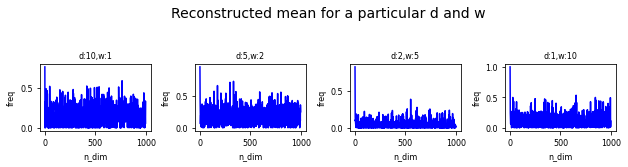

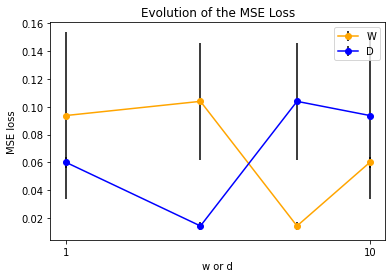

In [32]:
## Generating dataset
num_samples = 100
n_dims = 1000 # Input dimention
alpha = 1.5
beta = 0.5
ps = get_zipf_probs(n_dims, alpha, beta)
x = torch.bernoulli(ps.repeat(num_samples,1))
mean_dataset(x)

## Creating count-min sketch
list_w = [1,2,5,10] # Increasing
list_d = [10,5,2,1] # Decreasing

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'zipf',0)
MSE_plot(list_w,list_d,loss)

In [10]:
n_dims = 1000 # Input dimention

## Creating count-min sketch
list_w = [1,2,5,10]
list_d = [10,5,2,1] 

err_cs,err_cm,space_alpha = count_algorithms(list_w,list_d,n_dims)
MSE_plot_count(list_w,list_d,err_cs,err_cm,space_alpha)

# Genetics dataset

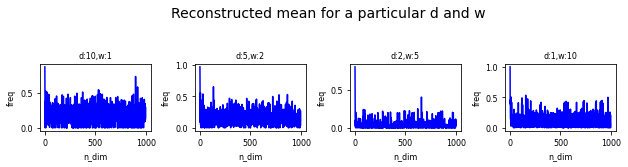

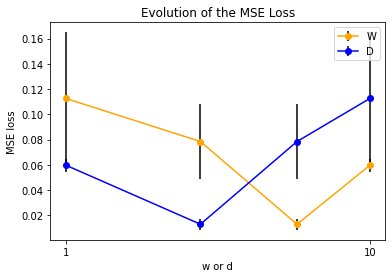

In [34]:
## Generating dataset
num_samples = 100
n_dims = 1000 # Input dimention
alpha = 1.5
beta = 0.5
ps = get_zipf_probs(n_dims, alpha, beta)
x = torch.bernoulli(ps.repeat(num_samples,1))
mean_dataset(x)

## Creating count-min sketch
list_w = [1,2,5,10]
list_d = [10,5,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'zipf',0)
MSE_plot(list_w,list_d,loss)

## Sketch size = d * w = 100 (input dimention)

#### count sketch

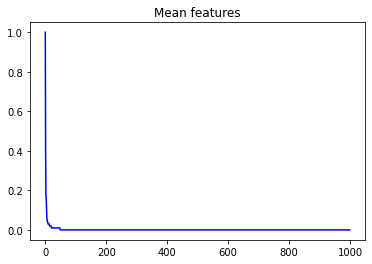

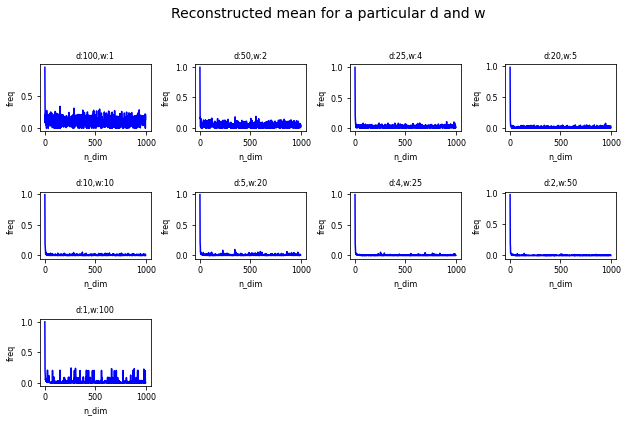

In [35]:
idx = plot_mean_features(x)

## Creating count-min sketch
n_dims = 1000

list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_sketch(list_w,list_d,n_dims,x.float(),x_1,x_2,x_3,'Genetics',idx)
MSE_plot(list_w,list_d,loss)

#### count min sketch

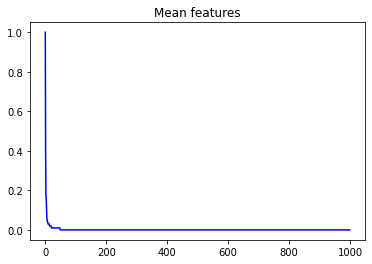

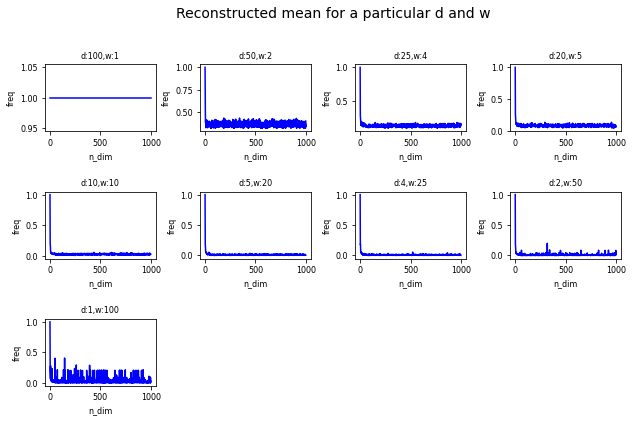

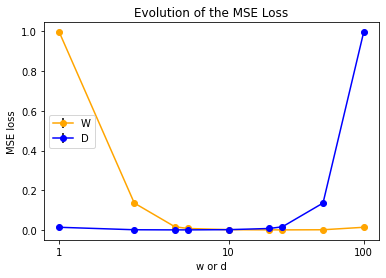

In [36]:
idx = plot_mean_features(x)

## Creating count-min sketch
n_dims = 1000

list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_min_sketch(list_w,list_d,n_dims,x.float(),x_1,x_2,x_3,'Genetics',idx)
MSE_plot(list_w,list_d,loss)

# MNIST dataset

In [37]:
# Read data
x = torch.from_numpy(data_MNIST['train']).float()
idx = plot_mean_features(x)

## Sketch size = d * w = 100 (input dimention)

#### Count min sketch

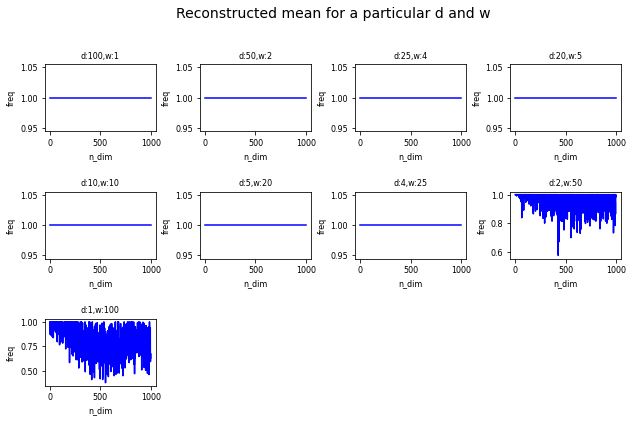

In [38]:
## Creating count-min sketch
n_dims = 1000

list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_min_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'MNIST',idx)
MSE_plot(list_w,list_d,loss)

#### Count sketch

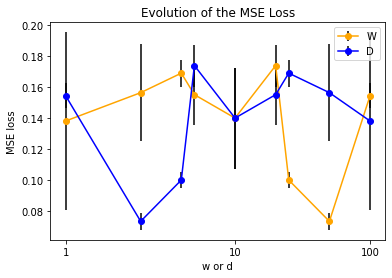

In [39]:
## Creating count-min sketch
n_dims = 1000

list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'MNIST',idx)
MSE_plot(list_w,list_d,loss)

## Sketch size = d * w = 100 (1 % input dimention)

#### Count min sketch

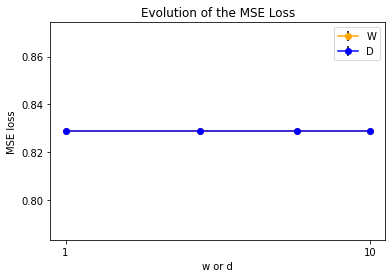

In [40]:
## Creating count-min sketch
n_dims = 1000

list_w = [1,2,5,10]
list_d = [10,5,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_min_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'MNIST',idx)
MSE_plot(list_w,list_d,loss)

#### Count sketch

In [41]:
## Creating count-min sketch
n_dims = 1000

list_w = [1,2,5,10]
list_d = [10,5,2,1] 

x_1 = 5 # rows
x_2 = 4  # columns
x_3 = 1
loss = count_sketch(list_w,list_d,n_dims,x,x_1,x_2,x_3,'MNIST',idx)
MSE_plot(list_w,list_d,loss)